In [1]:
import numpy as np
import pandas as pd
import os
import socket
import platform
from pathlib import Path
import time
import glob
import re
import gc

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from dask.distributed import Client
from IPython.display import IFrame

from tqdm.notebook import tqdm

from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.linear_model import (LinearRegression,
                                  TheilSenRegressor,
                                  RANSACRegressor,
                                  HuberRegressor,
                                  RidgeCV,
                                  LassoCV)
import scipy.stats as stats
from scipy.signal import convolve2d, savgol_filter

import mrcfile
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

from SIFT_gs.FIBSEM_SIFT_gs import FIBSEM_frame, FIBSEM_dataset
from SIFT_gs.FIBSEM_SIFT_gs import get_min_max_thresholds
from SIFT_gs.FIBSEM_SIFT_gs import (ShiftTransform,
                                    XScaleShiftTransform,
                                    ScaleShiftTransform,
                                    RegularizedAffineTransform)
            
from SIFT_gs.FIBSEM_SIFT_gs import (check_DASK,
                                    generate_report_mill_rate_xlsx,
                                    generate_report_FOV_center_shift_xlsx,
                                    generate_report_data_minmax_xlsx,
                                    generate_report_ScanRate_EHT_xlsx,
                                    generate_report_transf_matrix_from_xlsx,
                                    generate_report_from_xls_registration_summary,
                                    plot_registrtion_quality_xlsx,
                                    read_kwargs_xlsx)
                        
from SIFT_gs.FIBSEM_SIFT_gs import plot_cross_sections_mrc_stack, add_scale_bar
from SIFT_gs.FIBSEM_SIFT_gs import (bin_crop_mrc_stack,
                                    show_eval_box_mrc_stack)
from SIFT_gs.FIBSEM_SIFT_gs import plot_2D_blob_results, plot_2D_blob_examples
from SIFT_gs.FIBSEM_SIFT_gs import build_kernel_FFT_zero_destreaker_XY, build_kernel_FFT_zero_destreaker_radii_angles
from SIFT_gs.FIBSEM_SIFT_gs import (destreak_mrc_stack_with_kernel,
                                    destreak_single_frame_kernel_shared,
                                    smooth_mrc_stack_with_kernel)
from SIFT_gs.FIBSEM_SIFT_gs import (analyze_edge_transitions_image,
                                    plot_edge_transition_analysis_details,
                                    plot_edge_transition_points_map,
                                    plot_edge_transition_examples)
from SIFT_gs.FIBSEM_SIFT_gs import (radial_profile,
                                    Two_Image_FSC,
                                    Two_Image_NCC_SNR,
                                    Single_Image_SNR,
                                    calculate_gradent_map,
                                    Single_Image_Noise_Statistics)
    
from datetime import datetime

skimage version:  0.19.2
scipy version:    1.9.1
sklearn version:  1.0.2
Open CV version:  4.10.0
SIFT_gs version:  4.0.1


In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
use_DASK, status_update_address = check_DASK(client)
IFrame(src=status_update_address, width='100%', height='900px')

C:\Users\labadmin\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63916 instead
  warnings.warn(


DASK client exists. Will perform distributed computations
Use http://shtengelg-ww10:63916/status to monitor DASK progress


In [3]:
def Single_Image_Noise_Statistics_loc(params):
    test_img, filter_array, DarkCount = params
    res_loc = Single_Image_Noise_Statistics(test_img,
                                            filter_array=filter_array,
                                            disp_res = False,
                                            img_label = image_name,
                                            DarkCount=DarkCount,
                                            save_res_png = False,
                                            res_fname = 'test')
    return res_loc[3]

In [4]:
def FSC_Samples_Offsets(frame, image, offsets, **kwargs):
    '''
    Estimates SNR based on a single image.
    ©G.Shtengel  gleb.shtengel@gmail.com
    Calculates SNR of a single image base on auto-correlation analysis after [1].
    
    Parameters
    ---------
    img : 2D array
     
    kwargs:
    edge_fraction : float
        fraction of the full autocetrrelation range used to calculate the "mean value" (default is 0.10)
    extrapolate_signal : boolean
        extrapolate to find signal autocorrelationb at 0-point (without noise). Default is True
    disp_res : boolean
        display results (plots) (default is True)
    save_res_png : boolean
        save the analysis output into a PNG file (default is True)
    res_fname : string
        filename for the result image ('SNR_result.png')
    img_label : string
        optional image label
    dpi : int
        dots-per-inch resolution for the output image
        
    Returns:
        xSNR, ySNR, rSNR : float, float, float
    '''
    title = kwargs.get('title', '')
    ax = kwargs.get('ax', '')
    if ax == '':
        fig, ax = plt.subplots(1,1, figsize = (7,5))
    cols = ['black', 'brown', 'r', 'b', 'g', 'cyan']
    results = []
    for j, offset in enumerate(offsets):
        if image == 'A':
            Raw1 = frame.RawSamplesA[:, :, 0::25].mean(axis=2)
            Raw2 = frame.RawSamplesA[:, :, offset::25].mean(axis=2)
        else:
            Raw1 = frame.RawSamplesB[:, :, 0::25].mean(axis=2)
            Raw2 = frame.RawSamplesB[:, :, offset::25].mean(axis=2)
        res = Two_Image_FSC(Raw1, Raw2, disp_res=False)
        ax.plot(res[0], res[1], color=cols[j], label = '{:d} pt. offset'.format(offset))
    ax.grid(True)
    ax.set_xlim((0, 0.5))
    ax.legend()
    ax.set_title(title, fontsize = 10)
    ax.set_xlabel('Spatial Frequency (inverse pixels)')
    ax.set_ylabel('FSC Magnitude')
    results.append(res)
    return results

def autocorrelation(arr, **kwargs):
    '''
    
    '''
    edge_fraction = kwargs.get("edge_fraction", 0.10)
    
    disp_res = kwargs.get("disp_res", True)
    nbins_disp = kwargs.get("nbins_disp", 256)
    thresholds_disp = kwargs.get("thresholds_disp", [1e-3, 1e-3])
    save_res_png = kwargs.get("save_res_png", True)
    res_fname = kwargs.get("res_fname", 'SNR_results.png')
    arr_label = kwargs.get("arr_label", 'Orig. Image')
    dpi = kwargs.get("dpi", 300)
    zeromean = kwargs.get('zeromean', True)
    
    #first make image size even
    dd = len(arr)
    if zeromean:
        data_FT = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(arr-arr.mean())))
    else:
        data_FT = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(arr)))
    data_FC = (np.multiply(data_FT,np.conj(data_FT)))/dd/dd
    #data_ACR = np.abs(np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data_FC))))
    data_ACR = np.abs((np.fft.fftn(np.fft.ifftshift(data_FC))))
    return data_ACR[0:dd//2]/data_ACR[0]


def autocorrelate_oversamples(img, **kwargs):
    '''
    
    '''
    edge_fraction = kwargs.get("edge_fraction", 0.10)
    
    disp_res = kwargs.get("disp_res", True)
    nbins_disp = kwargs.get("nbins_disp", 256)
    thresholds_disp = kwargs.get("thresholds_disp", [1e-3, 1e-3])
    save_res_png = kwargs.get("save_res_png", True)
    res_fname = kwargs.get("res_fname", 'SNR_results.png')
    arr_label = kwargs.get("arr_label", 'Orig. Image')
    dpi = kwargs.get("dpi", 300)
    zeromean = kwargs.get('zeromean', True)
    returnmean = kwargs.get('returnmean', True)
    ysz, xsz, samples = img.shape
    img = img[0:((ysz+1)//2*2-1), 0:((xsz+1)//2*2-1), :]
    ysz, xsz, samples = img.shape
    if zeromean:
        img = img - np.expand_dims(img.mean(axis=2), axis=2)
    data_FT = np.fft.fft(img, axis = 2)
    data_FC = (np.multiply(data_FT,np.conj(data_FT)))/xsz/ysz/samples
    data_ACR = np.abs(np.fft.fft(data_FC, axis = 2))
    data_ACR = data_ACR[:, :, 0:samples//2]/data_ACR[:, :, 0 , None]
    if returnmean:
        data_ACR = np.mean(np.mean(data_ACR, axis=1), axis=0)
    return data_ACR

In [5]:
data_dir = '//nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/D21'
fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs)


Total Number of frames to process:  492


In [6]:
fls[6]

'//nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/D21\\Gemini450-0113_24-11-21_001722_0-0-0.dat'

In [7]:
fls.index('//nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/D21\\Gemini450-0113_24-11-21_064338_0-0-0.dat')

158

In [8]:
data_dir = '//nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/SNR_S2C4_J10_20241121'
fr_ind = 158
filename = fls[fr_ind]

header scaling data: [[ 2.00000000e+06  2.00000000e+06]
 [-6.80220947e+03 -7.49144238e+03]
 [ 1.33051038e+00  1.01784274e-01]
 [ 1.00000000e-01  1.00000000e-01]]

The EM data range for display:            -4699.51 to -244.00
The EM data range for noise analysis:     -4701.09 to -3590.76

Used Dark Count Offset: -6802.21
Slope of linear fit with header offset: 11.67
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 220.22

Free Fit Offset: -8175.05
Slope of Free Fit: 7.65
Free Fit         : SNR0 <S^2>/<N^2> = 513.51
2024/12/11  12:45:44   results saved into the file: //nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/SNR_S2C4_J10_20241121\Gemini450-0113_24-11-21_064338_0-0-0_RawImageA_Noise_Analysis.png

The EM data range for display:            -6677.29 to -6590.74
The EM data range for noise analysis:     -6669.67 to -6611.51

Used Dark Count Offset: -7491.44
Slope of linear fit with header offset: 0.87
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 978.85

Free Fit Offset: -6717.98
Slope of Free Fit

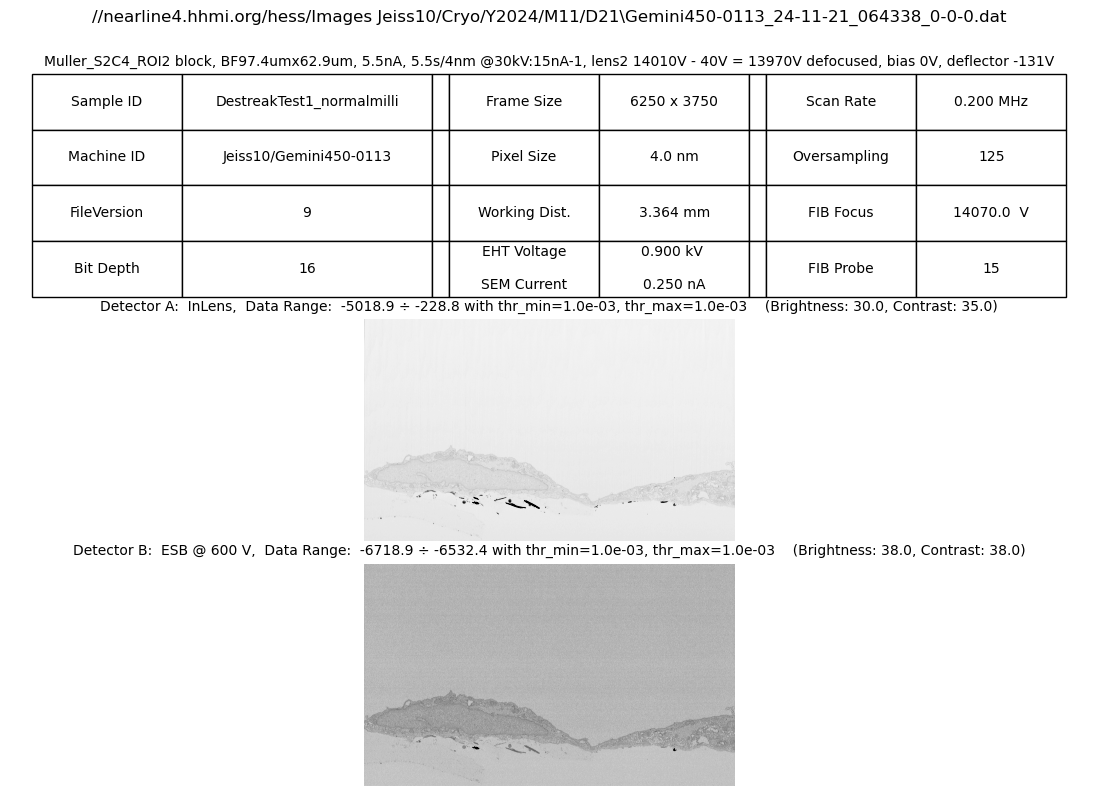

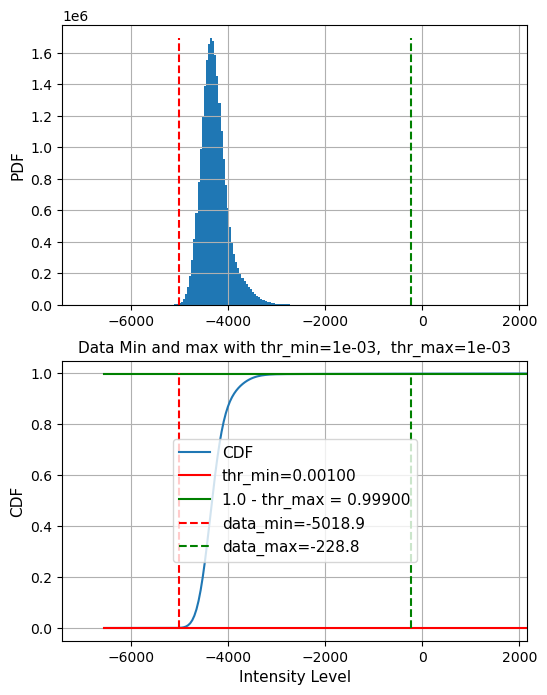

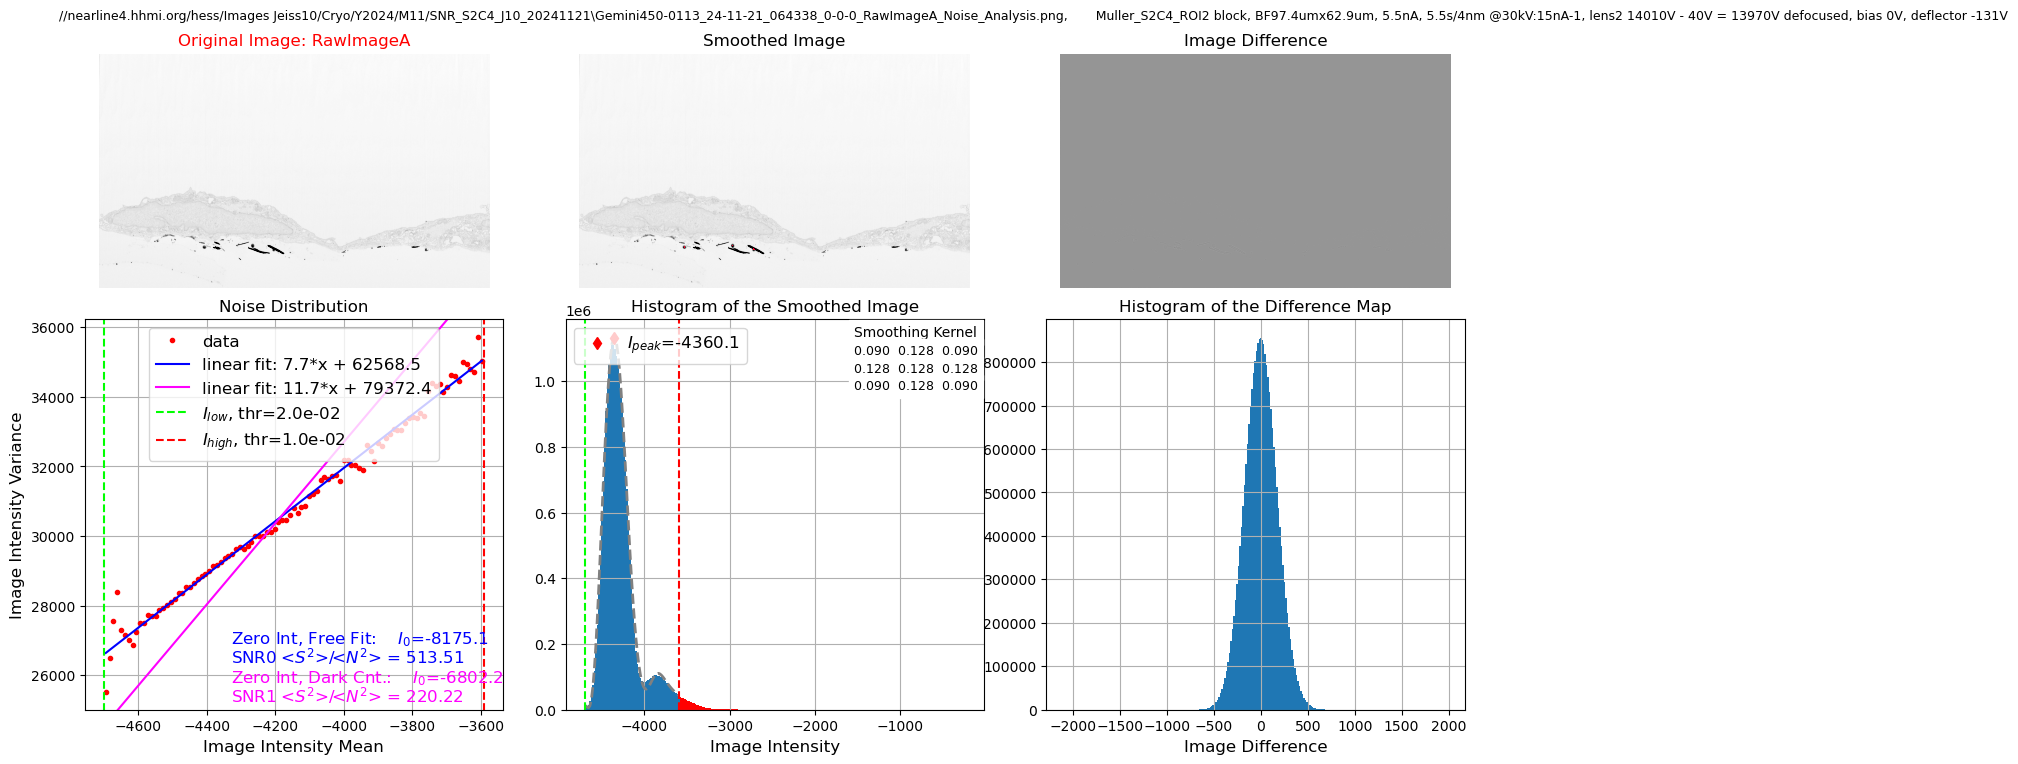

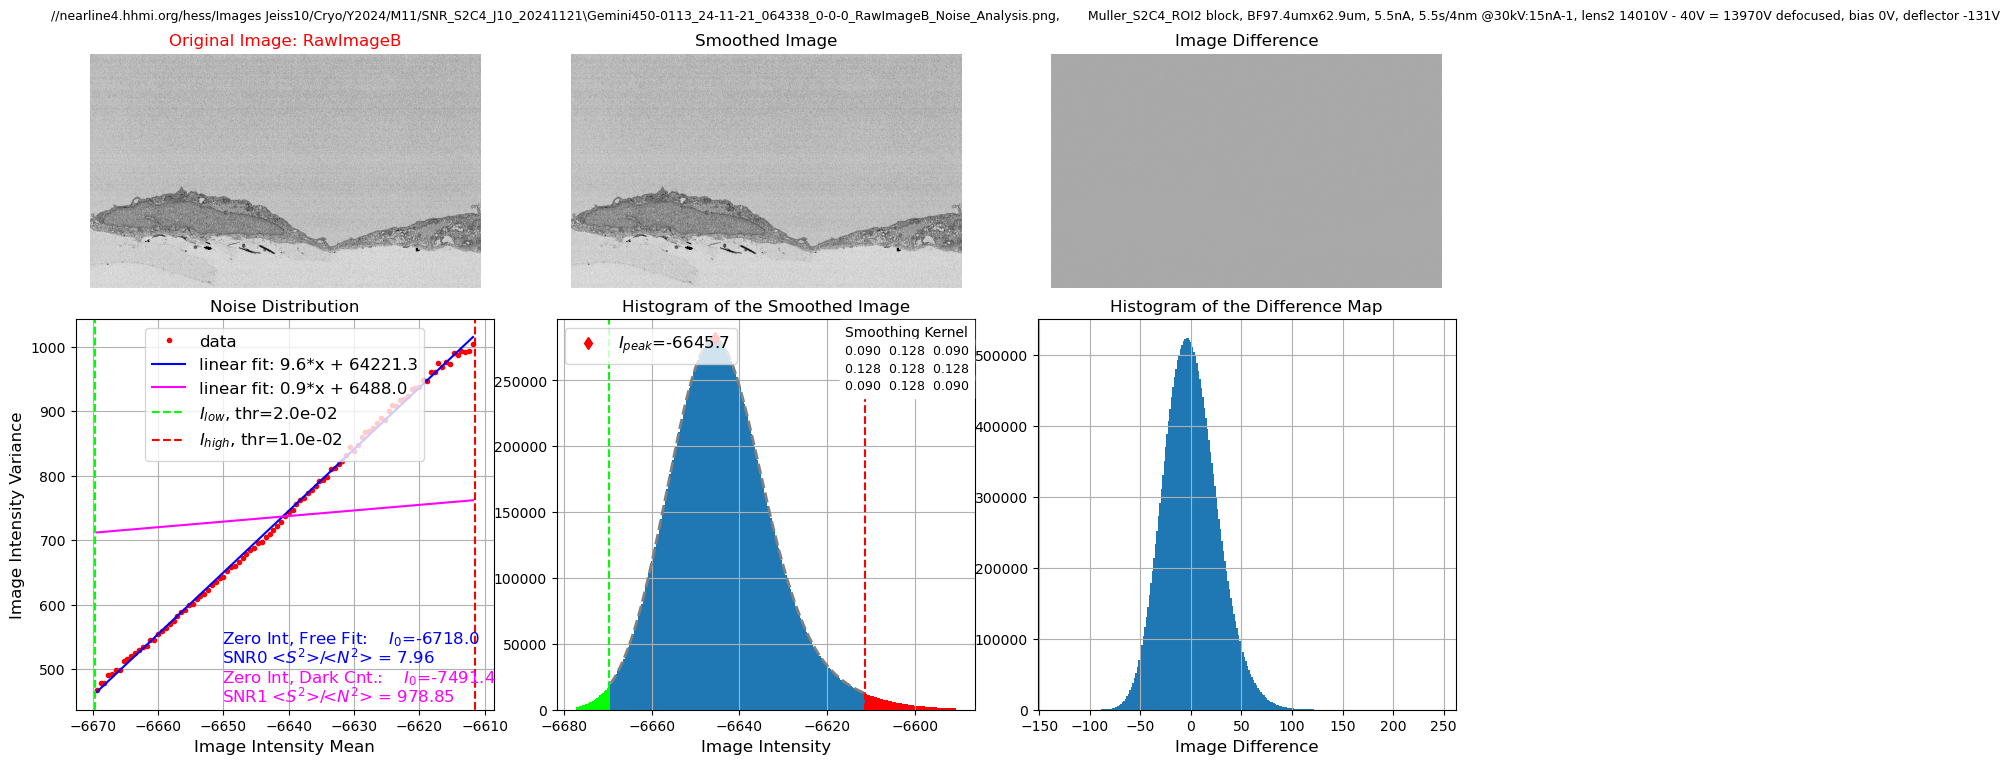

In [9]:
test_frame = FIBSEM_frame(filename)
snapshot_name = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_snapshot.png'))
test_frame.save_snapshot(snapshot_name=snapshot_name)
get_min_max_thresholds(test_frame.RawImageA, disp_res=True)
test_frame.save_images_tif()

print('header scaling data:', test_frame.Scaling)
image_name = 'RawImageA'
res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_' + image_name + '_Noise_Analysis.png'))
RawImageA_results = test_frame.analyze_noise_statistics(image_name=image_name, res_fname = res_fname)
image_name = 'RawImageB'
res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_' + image_name + '_Noise_Analysis.png'))
RawImageA_results = test_frame.analyze_noise_statistics(image_name=image_name, res_fname = res_fname)

# Determine SNR from Simulated Variance vs. Intensity Curve

## Use all pixels - no Gradient Filter

Analyzing SNR (Variance Curves) for sampling fractions:   0%|          | 0/7 [00:00<?, ?it/s]


The EM data range for display:            -4699.51 to -244.00
The EM data range for noise analysis:     -4701.09 to -3590.76

Used Dark Count Offset: -6802.21
Slope of linear fit with header offset: 11.67
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 220.22

Free Fit Offset: -8175.05
Slope of Free Fit: 7.65
Free Fit         : SNR0 <S^2>/<N^2> = 513.51
2024/12/11  12:52:35   results saved into the file: //nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/SNR_S2C4_J10_20241121\Gemini450-0113_24-11-21_064338_0-0-0_RawImgA_1samples_Noise_Statistics.png

The EM data range for display:            -4700.35 to -242.62
The EM data range for noise analysis:     -4701.93 to -3490.05

Used Dark Count Offset: -6802.21
Slope of linear fit with header offset: 11.60
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 221.52

Free Fit Offset: -8129.54
Slope of Free Fit: 7.74
Free Fit         : SNR0 <S^2>/<N^2> = 502.02
2024/12/11  12:53:03   results saved into the file: //nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y20

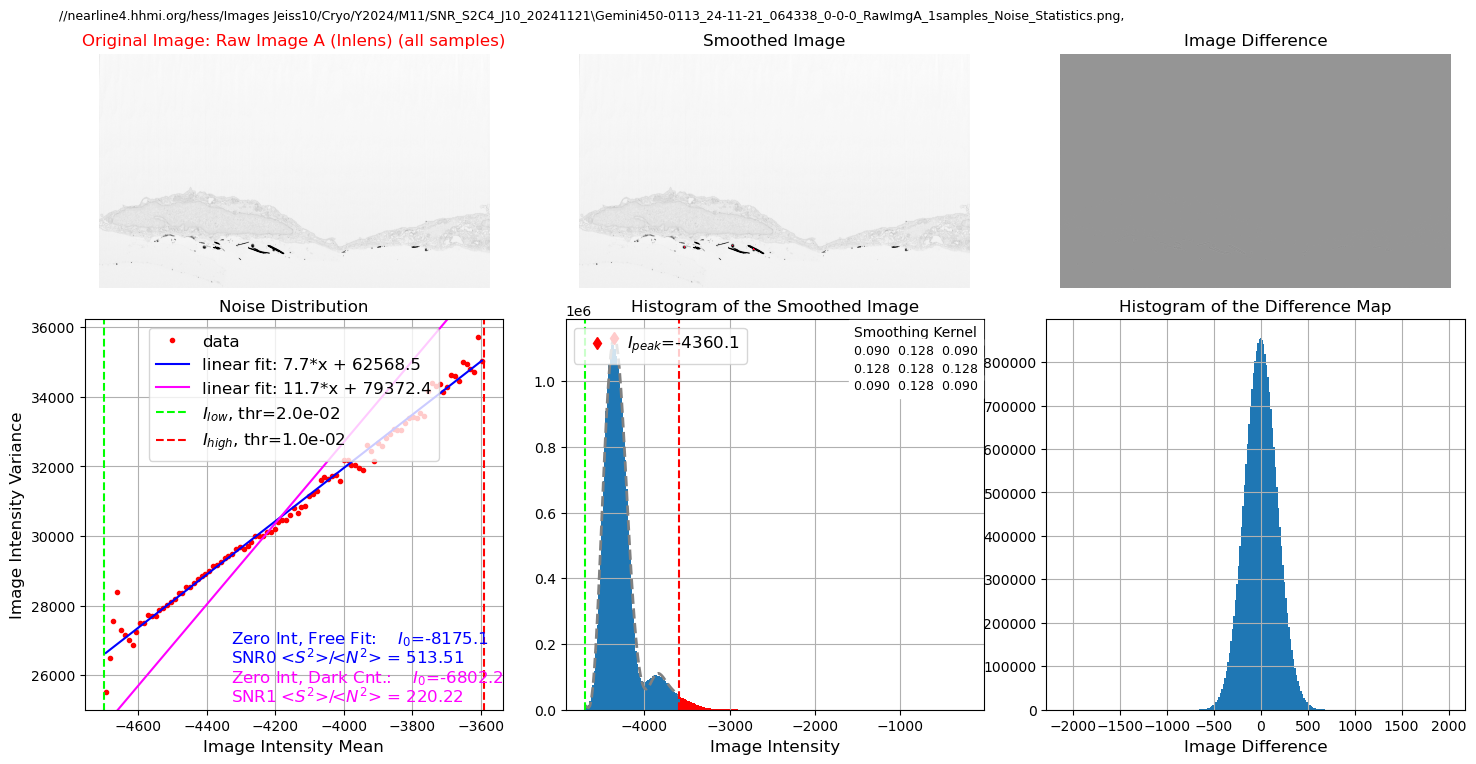

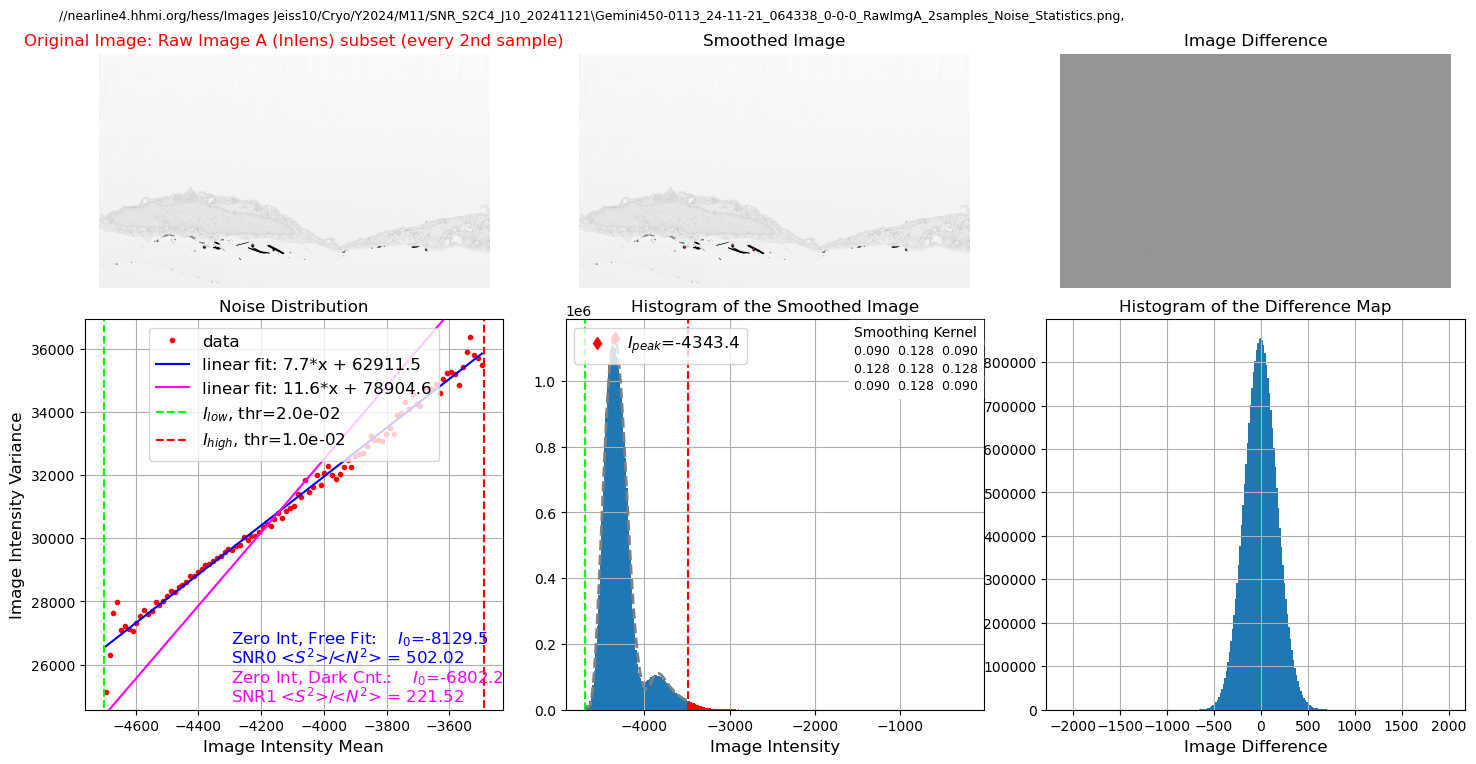

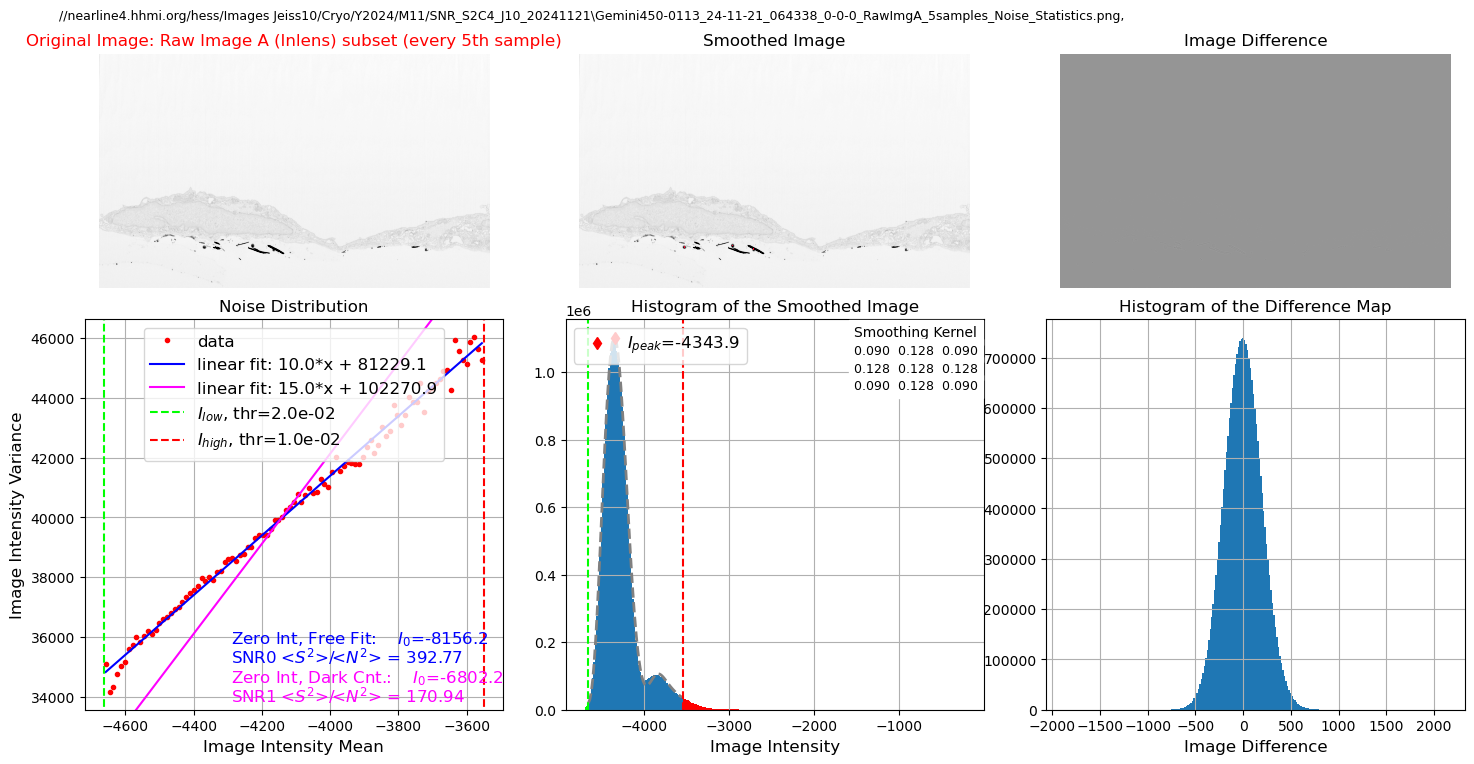

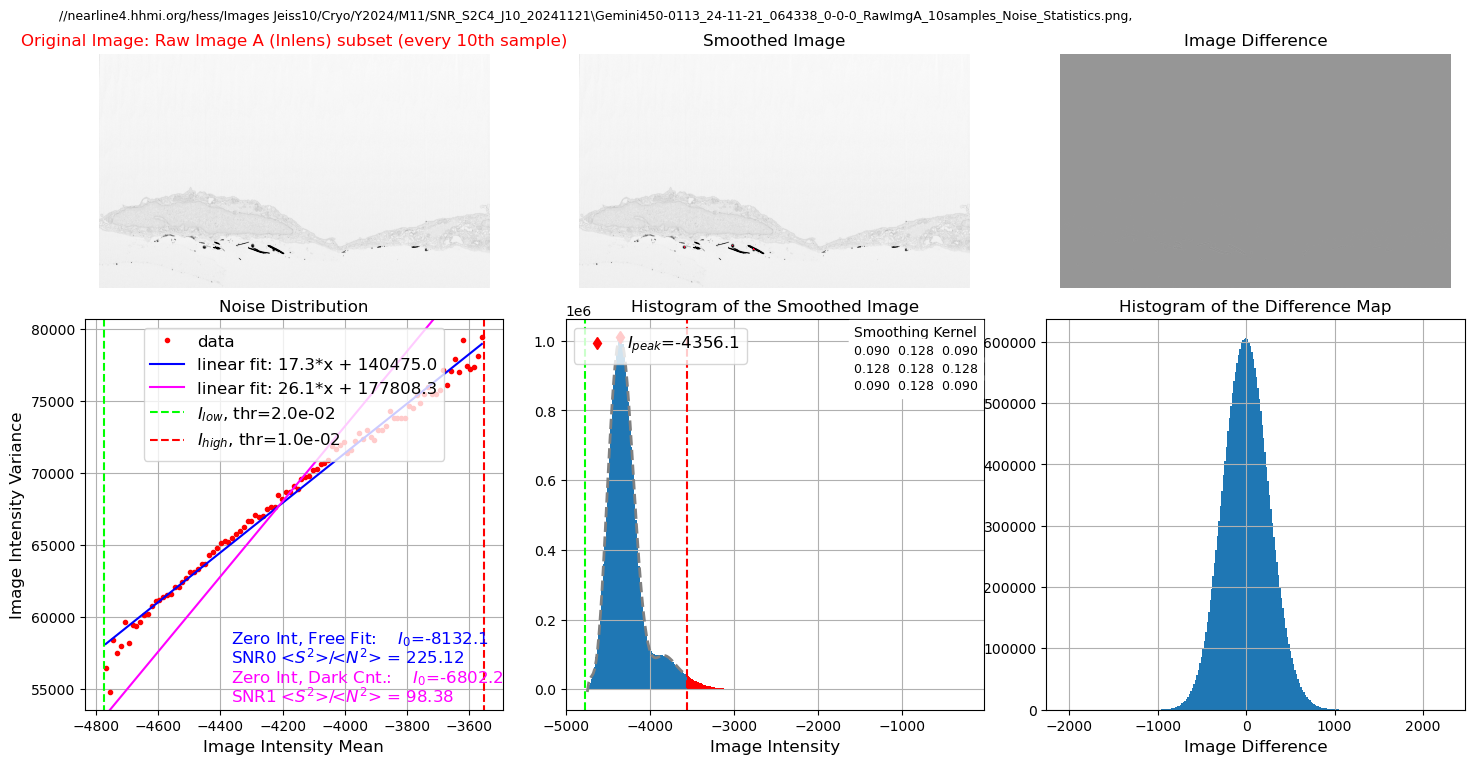

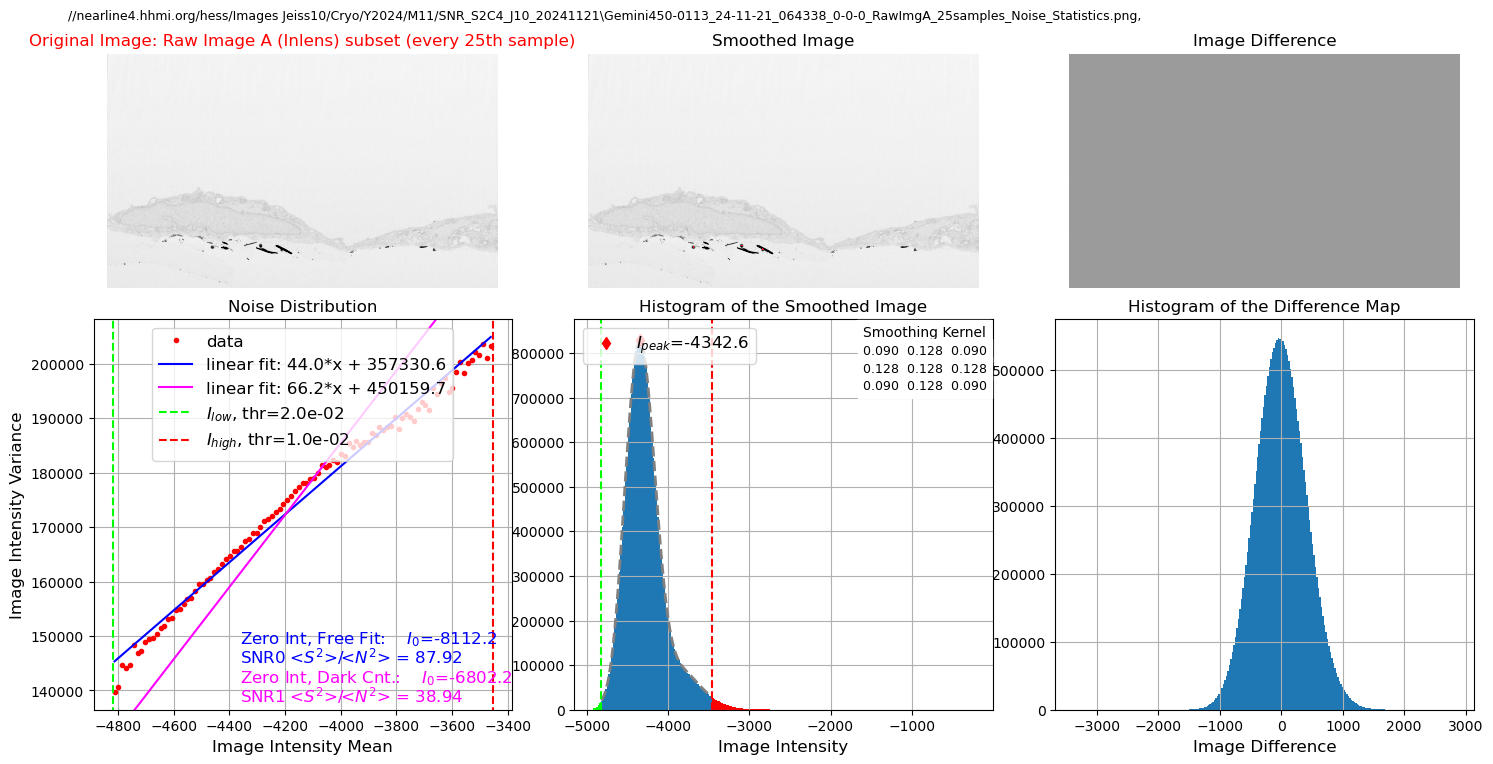

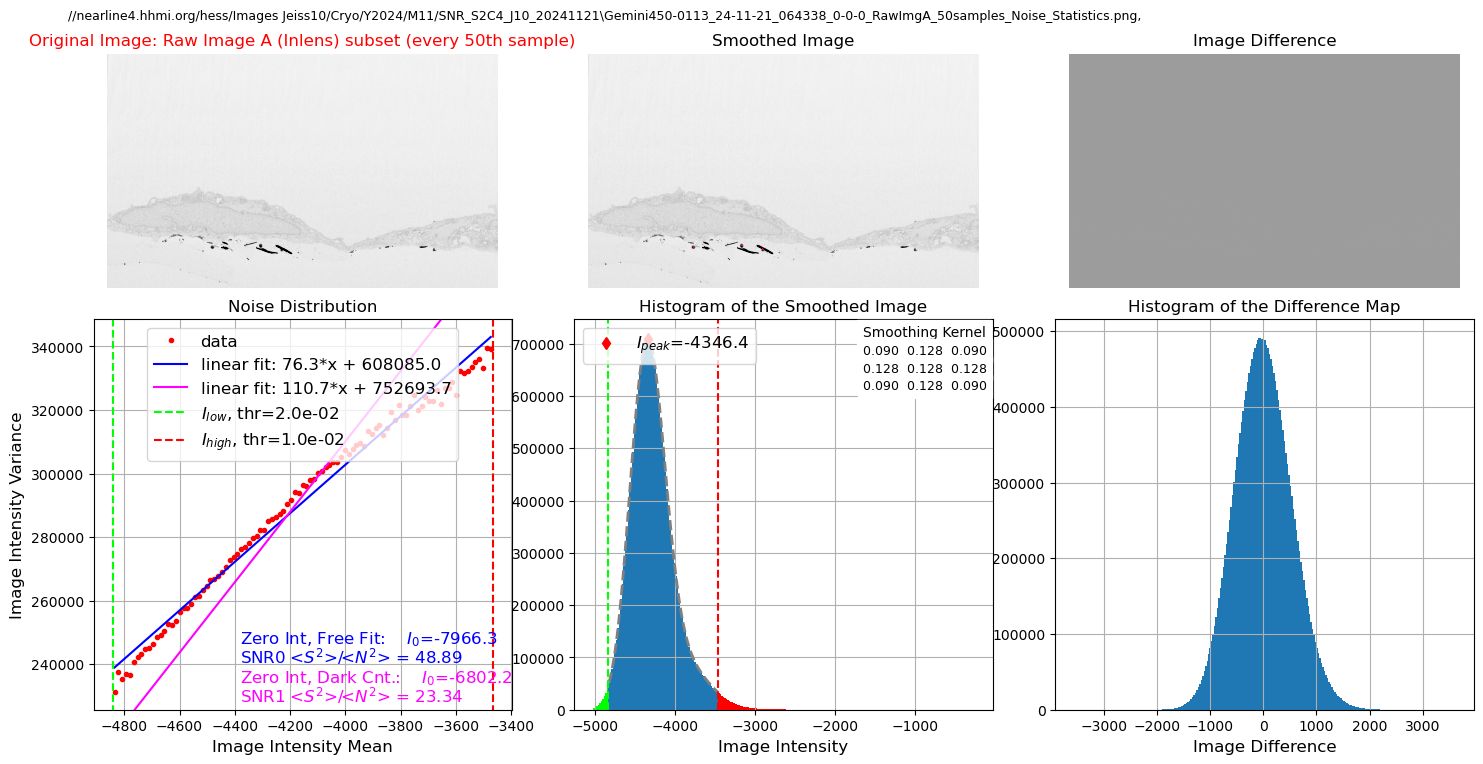

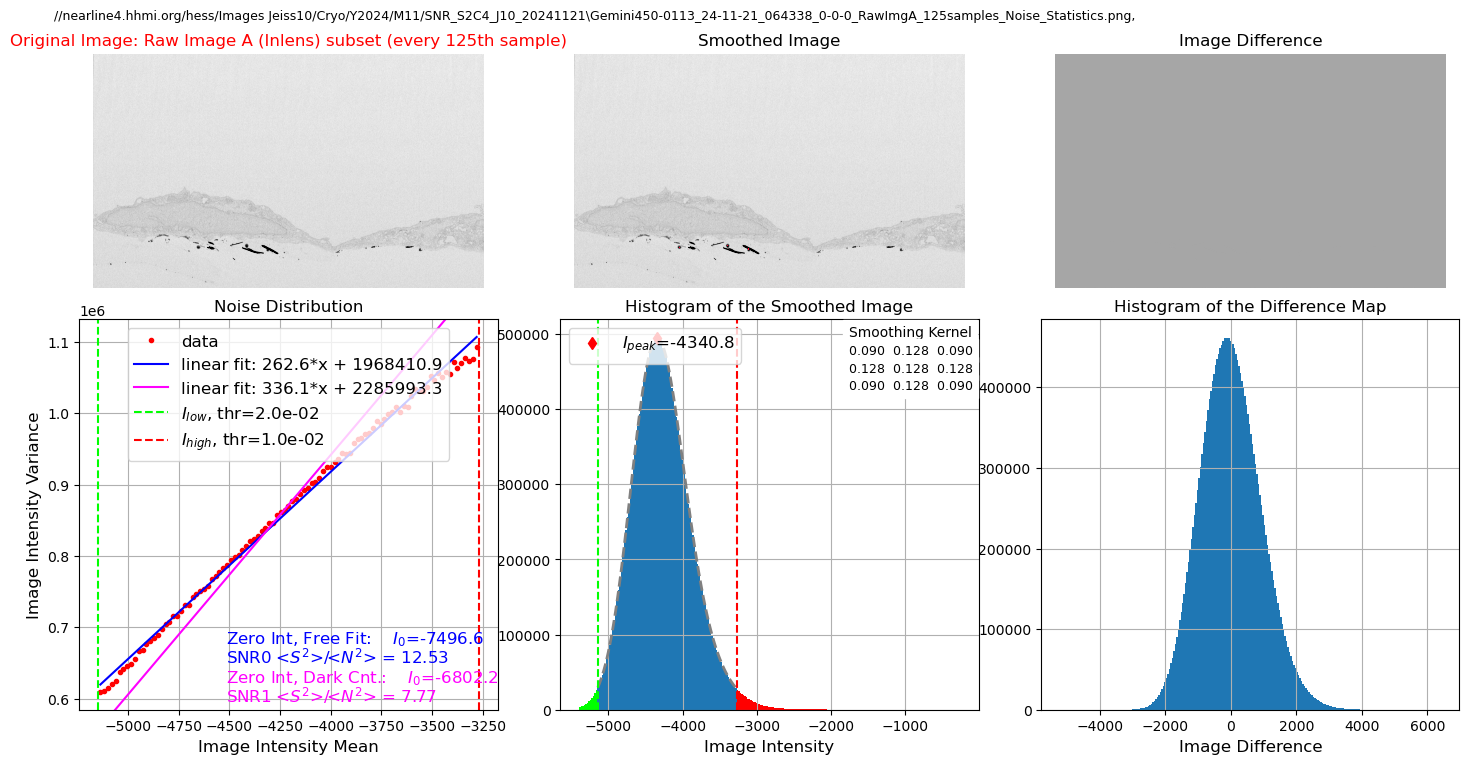

In [11]:
RawImgA_SNRs_Var_vs_Int = []
fractionsA_Var_vs_Int = []
for step in tqdm([1, 2, 5, 10, 25, 50, 125], desc = 'Analyzing SNR (Variance Curves) for sampling fractions'):
    fractionsA_Var_vs_Int.append(1.0 / step)
    RawA_s = test_frame.RawSamplesA[:, :, 0::step].mean(axis=2)
    if step == 1:
        img_label='Raw Image A (Inlens) (all samples)'
    if step == 2:
        img_label='Raw Image A (Inlens) subset (every 2nd sample)'
    if step > 2:
        img_label='Raw Image A (Inlens) subset (every {:d}th sample)'.format(step)
    #res_fname = filename.replace('.dat', '_RawImgA_{:d}samples_Noise_Statistics.png'.format(step))
    res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_{:d}samples_Noise_Statistics.png'.format(step)))
    res0 = Single_Image_Noise_Statistics(RawA_s,
                                     image_name = img_label,
                                     save_res_png  = True,
                                     res_fname  = res_fname,
                                    #filter_array = filter_array,
                                     DarkCount=test_frame.Scaling[1,0])
    RawImgA_SNRs_Var_vs_Int.append(res0[3])

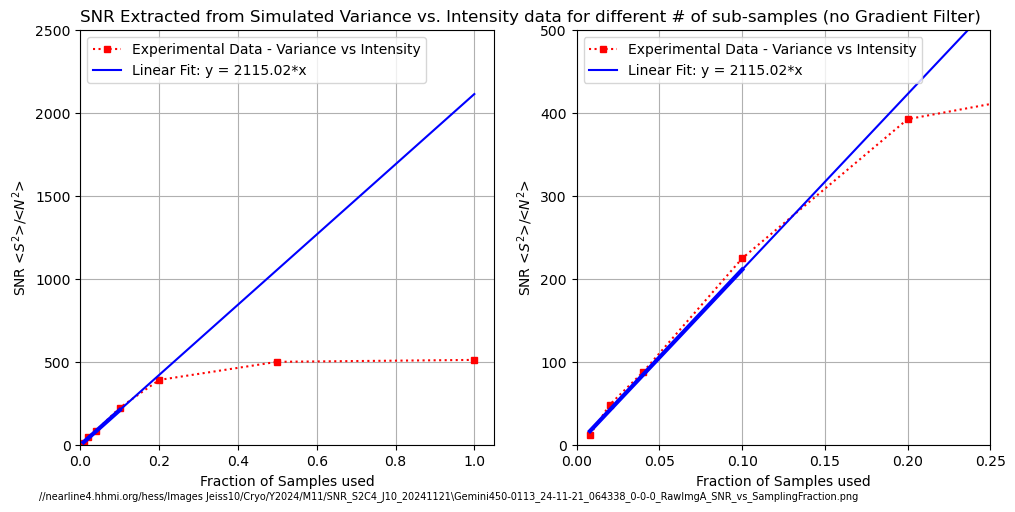

In [12]:
yy=4

slopeA_Var_vs_Int = np.mean(np.array(RawImgA_SNRs_Var_vs_Int[-yy:])/np.array(fractionsA_Var_vs_Int[-yy:]))
fitA_var_short = np.array(fractionsA_Var_vs_Int[-yy:]) * slopeA_Var_vs_Int
fitA_var = np.array(fractionsA_Var_vs_Int) * slopeA_Var_vs_Int

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)

for ax in axs:
    ax.plot(fractionsA_Var_vs_Int, RawImgA_SNRs_Var_vs_Int, 'rs', linestyle='dotted', markersize=5, label = 'Experimental Data - Variance vs Intensity')
    ax.plot(fractionsA_Var_vs_Int[-yy:], fitA_var_short, 'b', linewidth=3)
    ax.plot(fractionsA_Var_vs_Int, fitA_var, 'b', label = 'Linear Fit: y = {:.2f}*x'.format(slopeA_Var_vs_Int))
    ax.grid(True)
    ax.set_xlabel('Fraction of Samples used')
    ax.set_ylabel('SNR <$S^2$>/<$N^2$>')
    ax.legend(loc='upper left')

#axs[0].text(0, 1.05, filename, transform=axs[0].transAxes, fontsize=10)
axs[0].set_xlim((0, 1.05))
axs[0].set_ylim((0, 2500))
axs[1].set_xlim((0, 0.25))
axs[1].set_ylim((0, 500))

ax.text(0.0, 1.02, 'SNR Extracted from Simulated Variance vs. Intensity data for different # of sub-samples (no Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_SNR_vs_SamplingFraction.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

Analyzing SNR (Variance Curves) for sampling fractions:   0%|          | 0/7 [00:00<?, ?it/s]


The EM data range for display:            -6677.29 to -6590.74
The EM data range for noise analysis:     -6669.67 to -6611.51

Used Dark Count Offset: -6802.21
Slope of linear fit with header offset: 4.52
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 35.22

Free Fit Offset: -6717.98
Slope of Free Fit: 9.56
Free Fit         : SNR0 <S^2>/<N^2> = 7.96
2024/12/11  12:57:01   results saved into the file: //nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M11/SNR_S2C4_J10_20241121\Gemini450-0113_24-11-21_064338_0-0-0_RawImgB_1samples_Noise_Statistics.png

The EM data range for display:            -6678.19 to -6589.94
The EM data range for noise analysis:     -6670.90 to -6611.60

Used Dark Count Offset: -6802.21
Slope of linear fit with header offset: 4.95
Fit w DarkCount  : SNR1 <S^2>/<N^2> = 32.19

Free Fit Offset: -6721.17
Slope of Free Fit: 10.08
Free Fit         : SNR0 <S^2>/<N^2> = 7.87
2024/12/11  12:57:30   results saved into the file: //nearline4.hhmi.org/hess/Images Jeiss10/Cryo/Y2024/M1

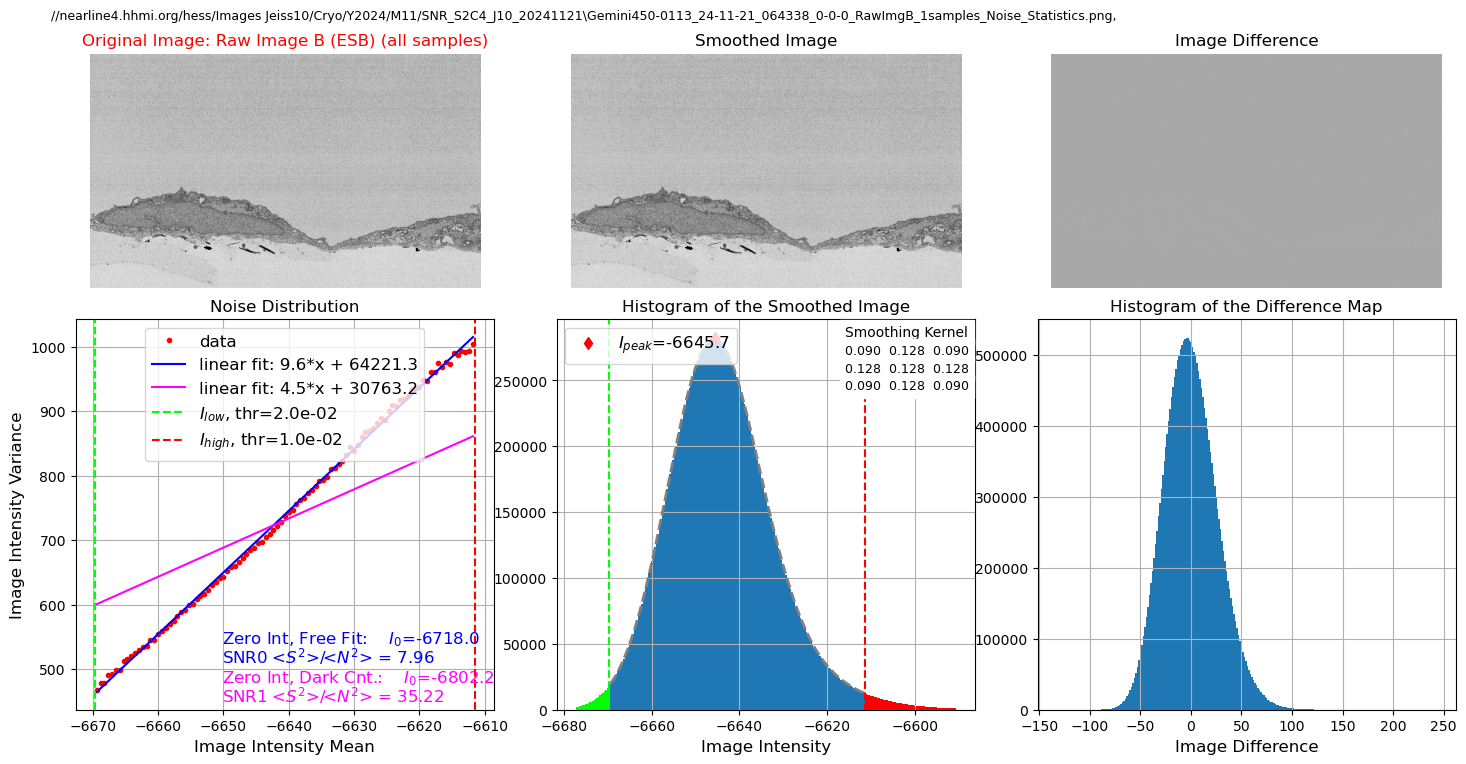

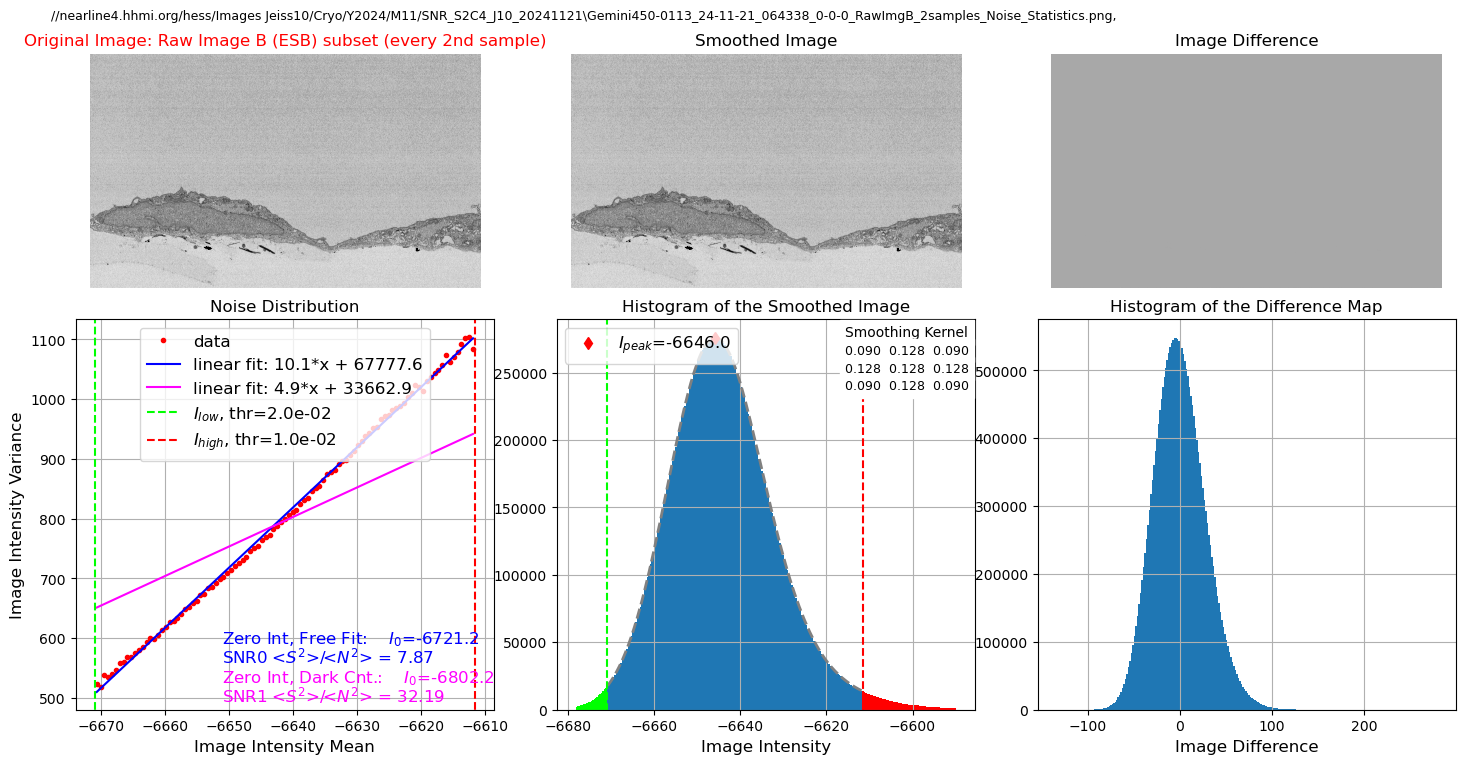

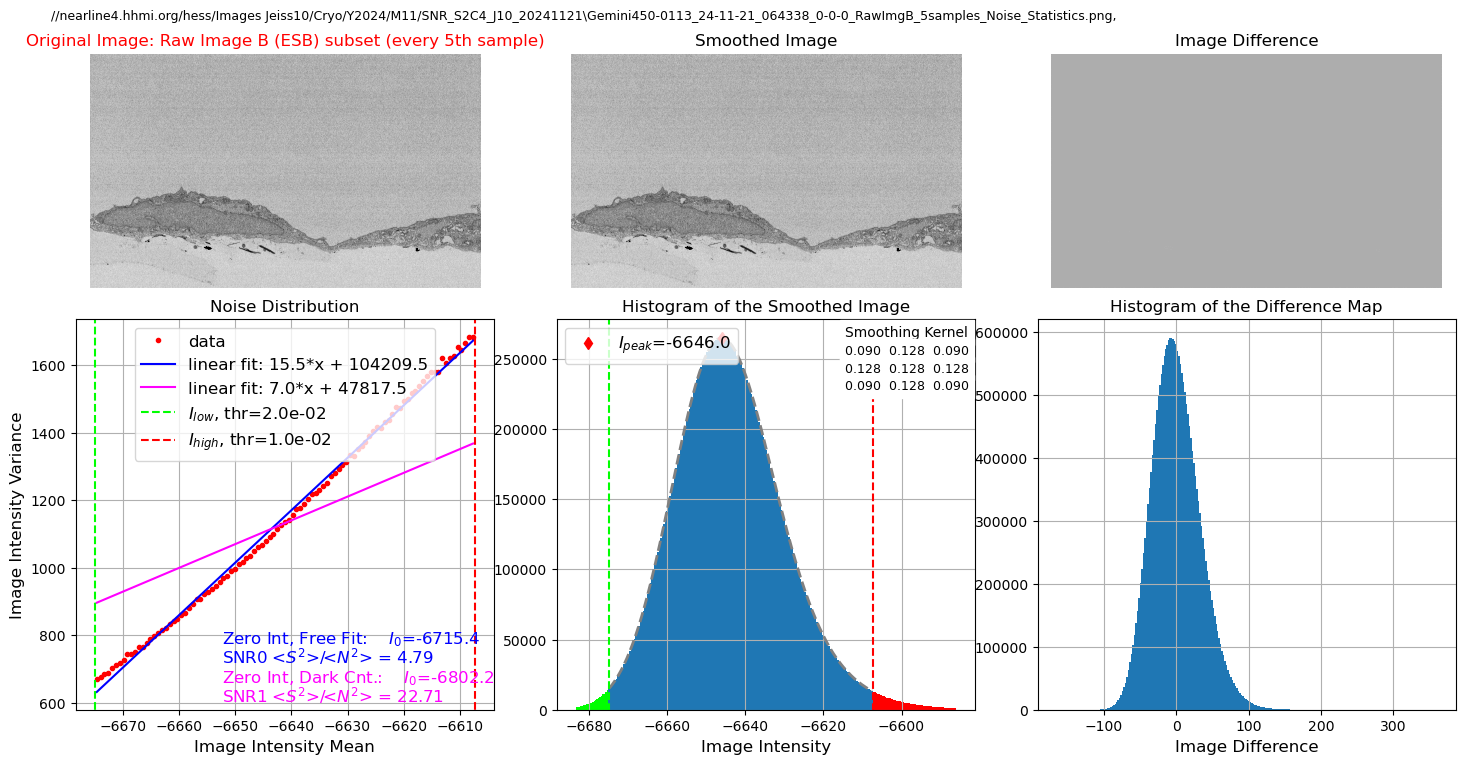

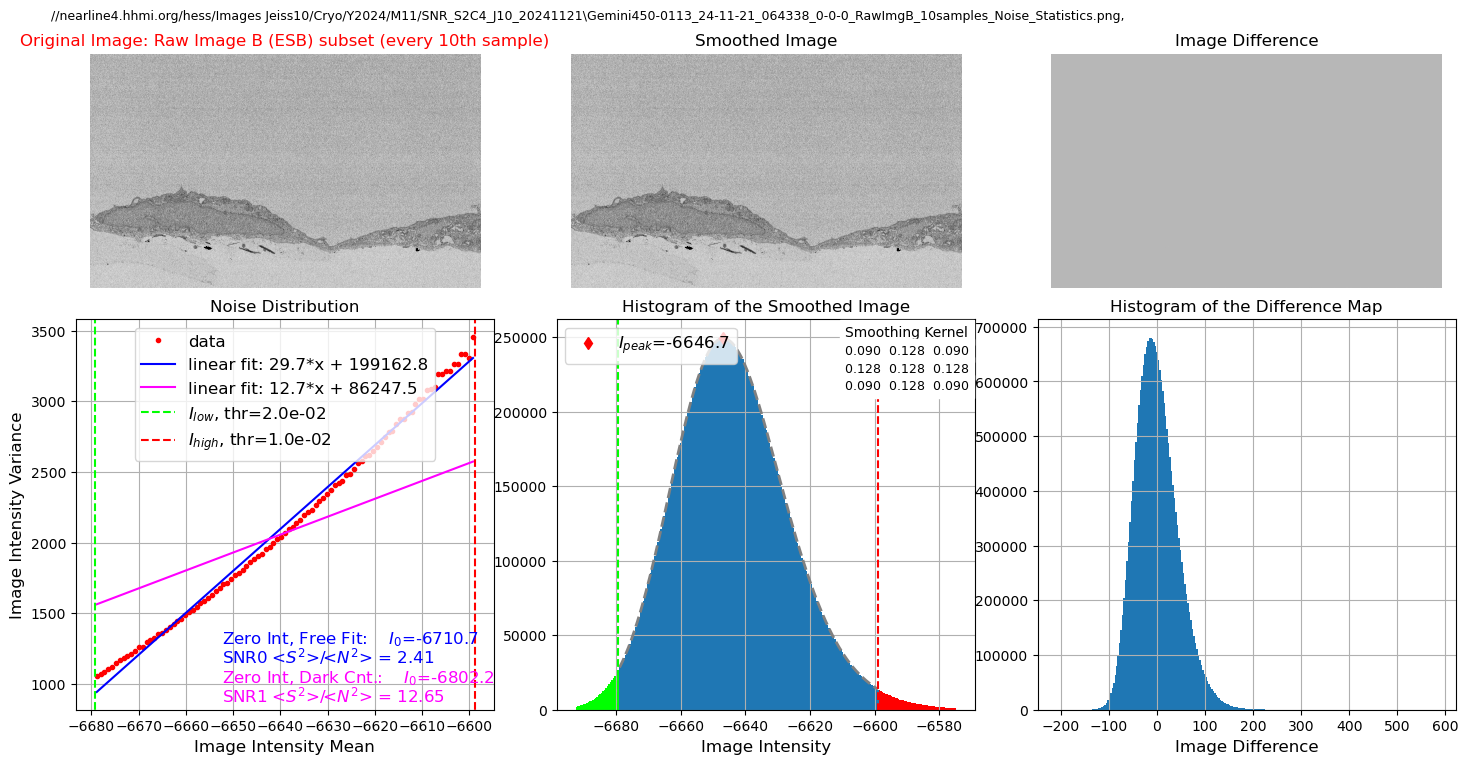

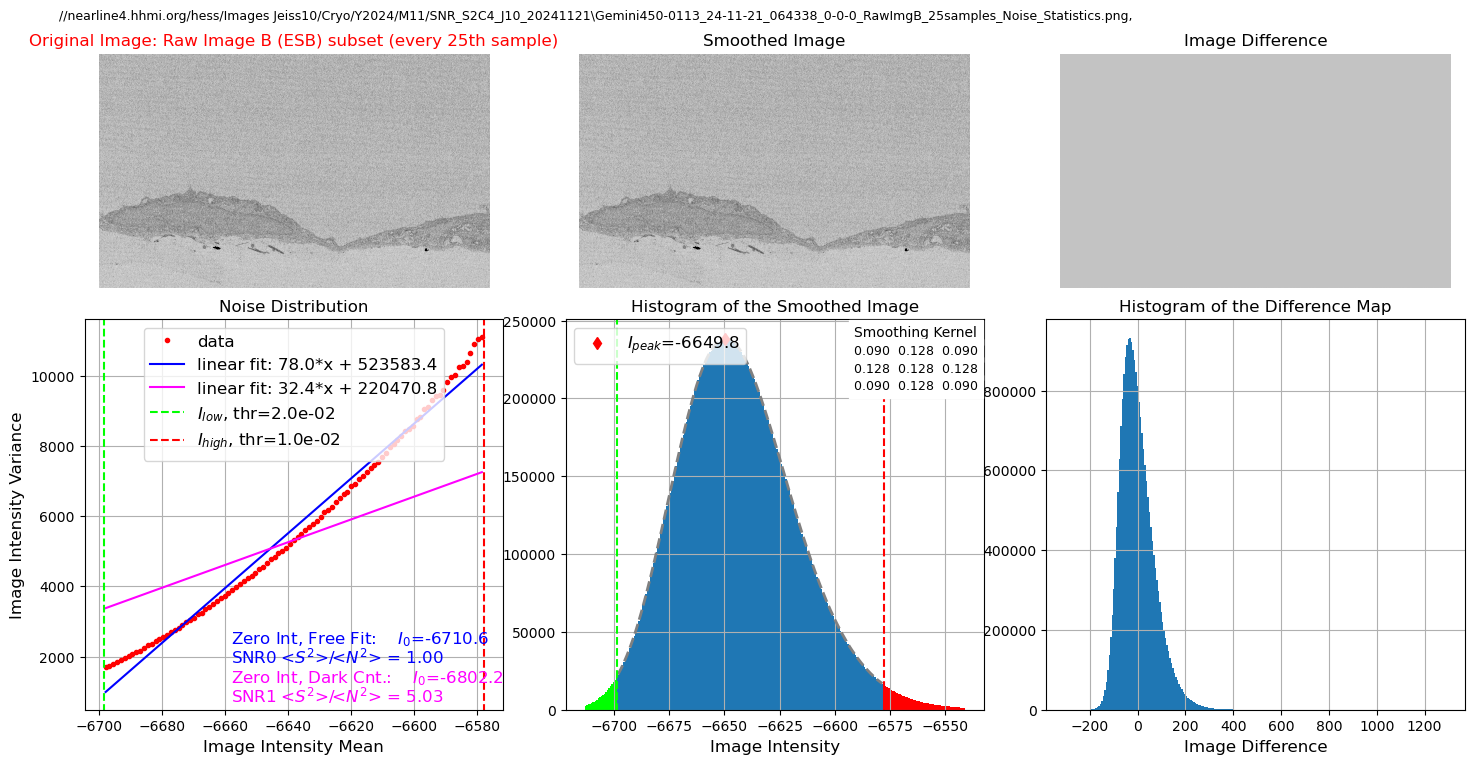

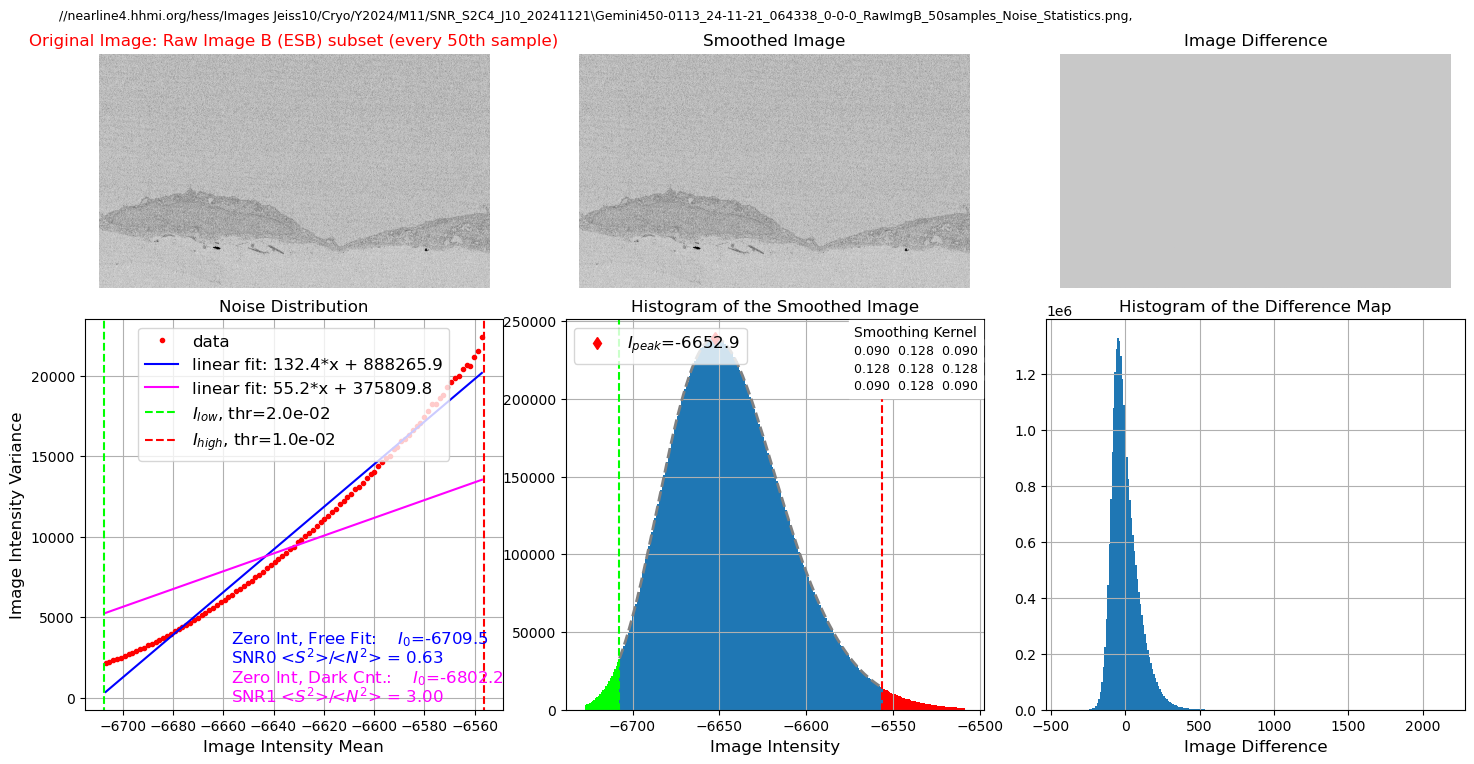

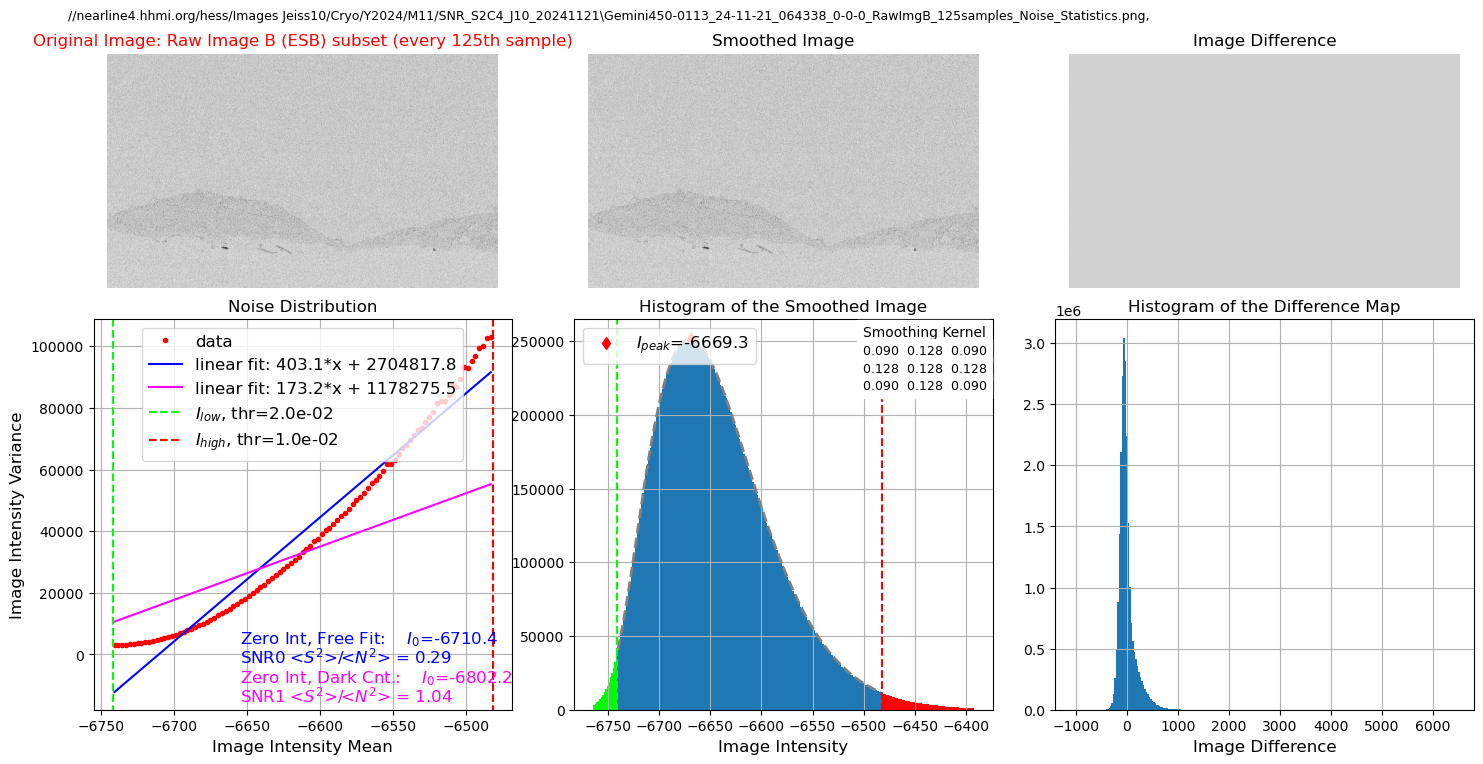

In [13]:
RawImgB_SNRs_Var_vs_Int = []
fractionsB_Var_vs_Int = []
for step in tqdm([1, 2, 5, 10, 25, 50, 125], desc = 'Analyzing SNR (Variance Curves) for sampling fractions'):
    fractionsB_Var_vs_Int.append(1.0 / step)
    RawB_s = test_frame.RawSamplesB[:, :, 0::step].mean(axis=2)
    if step == 1:
        img_label='Raw Image B (ESB) (all samples)'
    if step == 2:
        img_label='Raw Image B (ESB) subset (every 2nd sample)'
    if step > 2:
        img_label='Raw Image B (ESB) subset (every {:d}th sample)'.format(step)
    #res_fname = filename.replace('.dat', '_RawImgB_{:d}samples_Noise_Statistics.png'.format(step))
    res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgB_{:d}samples_Noise_Statistics.png'.format(step)))
    res0 = Single_Image_Noise_Statistics(RawB_s,
                                     image_name = img_label,
                                     save_res_png  = True,
                                     res_fname  = res_fname,
                                    #filter_array = filter_array,
                                     DarkCount=test_frame.Scaling[1,0])
    RawImgB_SNRs_Var_vs_Int.append(res0[3])

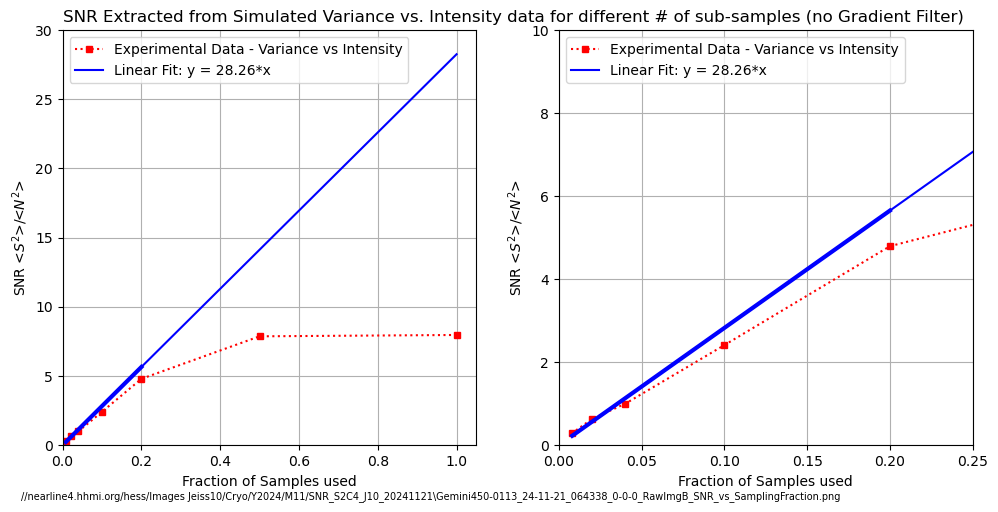

In [14]:
yy=5

slopeB_Var_vs_Int = np.mean(np.array(RawImgB_SNRs_Var_vs_Int[-yy:])/np.array(fractionsB_Var_vs_Int[-yy:]))
fitB_var_short = np.array(fractionsB_Var_vs_Int[-yy:]) * slopeB_Var_vs_Int
fitB_var = np.array(fractionsB_Var_vs_Int) * slopeB_Var_vs_Int

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)

for ax in axs:
    ax.plot(fractionsB_Var_vs_Int, RawImgB_SNRs_Var_vs_Int, 'rs', linestyle='dotted', markersize=5, label = 'Experimental Data - Variance vs Intensity')
    ax.plot(fractionsB_Var_vs_Int[-yy:], fitB_var_short, 'b', linewidth=3)
    ax.plot(fractionsB_Var_vs_Int, fitB_var, 'b', label = 'Linear Fit: y = {:.2f}*x'.format(slopeB_Var_vs_Int))
    ax.grid(True)
    ax.set_xlabel('Fraction of Samples used')
    ax.set_ylabel('SNR <$S^2$>/<$N^2$>')
    ax.legend(loc='upper left')

#axs[0].text(0, 1.05, filename, transform=axs[0].transAxes, fontsize=10)
axs[0].set_xlim((0, 1.05))
axs[0].set_ylim((0, 30))
axs[1].set_xlim((0, 0.25))
axs[1].set_ylim((0, 10))

ax.text(0.0, 1.02, 'SNR Extracted from Simulated Variance vs. Intensity data for different # of sub-samples (no Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgB_SNR_vs_SamplingFraction.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

## Use 0.1 Gradient Filter (use only pixels with local gradient no higher that 0.1 of max local gradient)

In [ ]:
grad_thr_min = 0.10
nbins=1000
abs_grad = calculate_gradent_map((test_frame.RawImageA-test_frame.Scaling[1,0]), normalize=False, thresholds_disp=[1e-2, 1e-2], disp_res=False)
gr_min, gr_max = get_min_max_thresholds(abs_grad, nbins=nbins, thr_min=grad_thr_min, disp_res=False)
filter_array = abs_grad<gr_min
print(filter_array.sum(), np.product(filter_array.shape), filter_array.sum()/np.product(filter_array.shape))

RawImgA_SNRs_Var_vs_Int_fr0p1 = []
fractions_Var_vs_Int_fr0p1 = []
for step in tqdm([1, 2, 5, 10, 25, 50, 125], desc = 'Analyzing SNR (Variance Curves) for sampling fractions'):
    fractions_Var_vs_Int_fr0p1.append(1.0 / step)
    RawA_s = test_frame.RawSamplesA[:, :, 0::step].mean(axis=2)
    if step == 1:
        img_label='Raw Image A (Inlens) (all samples)'
    if step == 2:
        img_label='Raw Image A (Inlens) subset (every 2nd sample)'
    if step > 2:
        img_label='Raw Image A (Inlens) subset (every {:d}th sample)'.format(step)
    #res_fname = filename.replace('.dat', '_RawImgA_{:d}samples_Noise_Statistics_GrThr{:.2f}.png'.format(step, grad_thr_min))
    res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_{:d}samples_Noise_Statistics_GrThr{:.2f}.png'.format(step, grad_thr_min)))
    res0 = Single_Image_Noise_Statistics(RawA_s,
                                     image_name = img_label,
                                     save_res_png  = True,
                                     res_fname  = res_fname,
                                    filter_array = filter_array,
                                     DarkCount=test_frame.Scaling[1,0])
    RawImgA_SNRs_Var_vs_Int_fr0p1.append(res0[3])

In [ ]:
yy=4

slope_Var_vs_Int_fr0p1 = np.mean(np.array(RawImgA_SNRs_Var_vs_Int_fr0p1[-yy:])/np.array(fractions_Var_vs_Int_fr0p1[-yy:]))
fit_var_fr0p1_short = np.array(fractions_Var_vs_Int_fr0p1[-yy:]) * slope_Var_vs_Int_fr0p1
fit_var_fr0p1 = np.array(fractions_Var_vs_Int_fr0p1) * slope_Var_vs_Int_fr0p1

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)

for ax in axs:
    ax.plot(fractions_Var_vs_Int_fr0p1, RawImgA_SNRs_Var_vs_Int_fr0p1, 'rs', linestyle='dotted', markersize=5, label = 'Experimental Data - Variance vs Intensity')
    ax.plot(fractions_Var_vs_Int_fr0p1[-yy:], fit_var_fr0p1_short, 'b', linewidth=3)
    ax.plot(fractions_Var_vs_Int_fr0p1, fit_var_fr0p1, 'b', label = 'Linear Fit: y = {:.2f}*x'.format(slope_Var_vs_Int_fr0p1))
    ax.grid(True)
    ax.set_xlabel('Fraction of Samples used')
    ax.set_ylabel('SNR <$S^2$>/<$N^2$>')
    ax.legend(loc='upper left')

#axs[0].text(0, 1.05, filename, transform=axs[0].transAxes, fontsize=10)
axs[0].set_xlim((0, 1.05))
axs[0].set_ylim((0, 2500))
axs[1].set_xlim((0, 0.25))
axs[1].set_ylim((0, 500))

ax.text(-0.05, 1.02, 'SNR Extracted from Simulated Variance vs. Intensity data for different # of sub-samples (with 0.1 Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_SNR_vs_SamplingFraction_GrThr{:.2f}.png'.format(grad_thr_min)))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

# Determine SNR from Auto-Correlation Data

In [ ]:
xc = 1000
yc = 500

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(test_frame.RawImageA[2000:3000, 0:3000],)
ax.plot([xc], [yc], 'r*', label='Pixel with coordinates X={:d}, Y={:d}'.format(xc, yc))
ax.grid(True)
ax.legend()

## Use all Pixels - no Gradient Filter

In [ ]:
# %%time

OffsetA = 8100

fractionsA_autocorr = []
RawImgA_s_rSNRs_autocorr = []
for step in tqdm([1, 2, 5, 10, 25, 50, 125], desc = 'Analyzing SNR (auto-correlation) for sampling fractions'):
    fractionsA_autocorr.append(1.0 / step)
    RawA_s = test_frame.RawSamplesA[2000:3000, 0:3000, 0::step]
    if step == 1:
        img_label='Raw Image A (all samples)'
    if step == 2:
        img_label='Raw Image A subset (every 2nd sample)'
    if step > 2:
        img_label='Raw Image A subset (every {:d}th sample)'.format(step)
    RawImgA_s_xSNR, RawImgA_s_ySNR, RawImgA_s_rSNR = Single_Image_SNR(RawA_s.mean(axis=2)+OffsetA,
                                                        extrapolate_signal=True,
                                                        zero_mean=False,
                                                        save_res_png=True,
                                                        res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_s{:d}_SNR.png'.format(step))),
                                                        #res_fname = test_frame.fname.replace('.dat', '_RawImgA_s{:d}_SNR.png'.format(step)),
                                                        img_label=img_label)
    RawImgA_s_rSNRs_autocorr.append(RawImgA_s_rSNR)

In [ ]:
yy=4

slopeA_autocorr = np.mean(np.array(RawImgA_s_rSNRs_autocorr[-yy:])/np.array(fractionsA_autocorr[-yy:]))
fitA_autocorr_short = np.array(fractionsA_autocorr[-yy:]) * slopeA_autocorr
fitA_autocorr = np.array(fractionsA_autocorr) * slopeA_autocorr

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)

for ax in axs:
    ax.plot(fractionsA_autocorr, RawImgA_s_rSNRs_autocorr, 'rs', linestyle='dotted', markersize=5, label = 'Experimental Data - Variance vs Intensity')
    ax.plot(fractionsA_autocorr[-yy:], fitA_autocorr_short, 'b', linewidth=3)
    ax.plot(fractionsA_autocorr, fitA_autocorr, 'b', label = 'Linear Fit: y = {:.2f}*x'.format(slopeA_autocorr))
    ax.grid(True)
    ax.set_xlabel('Fraction of Samples used')
    ax.set_ylabel('SNR <$S^2$>/<$N^2$>')
    ax.legend(loc='upper left')

#axs[0].text(0, 1.05, filename, transform=axs[0].transAxes, fontsize=10)
axs[0].set_xlim((0, 1.05))
axs[0].set_ylim((0, 2500))
axs[1].set_xlim((0, 0.25))
axs[1].set_ylim((0, 500))

ax.text(0.1, 1.02, 'SNR Extracted from Autocorrelation data for different # of sub-samples (no Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgA_SNR_Autocorr_vs_SamplingFraction.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

In [ ]:
# %%time

OffsetB = 6715

fractionsB_autocorr = []
RawImgB_s_rSNRs_autocorr = []
for step in tqdm([1, 2, 5, 10, 25, 50, 125], desc = 'Analyzing SNR (auto-correlation) for sampling fractions'):
    fractionsB_autocorr.append(1.0 / step)
    RawB_s = test_frame.RawSamplesB[2000:3000, 0:3000, 0::step]
    if step == 1:
        img_label='Raw Image A (all samples)'
    if step == 2:
        img_label='Raw Image A subset (every 2nd sample)'
    if step > 2:
        img_label='Raw Image A subset (every {:d}th sample)'.format(step)
    RawImgB_s_xSNR, RawImgB_s_ySNR, RawImgB_s_rSNR = Single_Image_SNR(RawB_s.mean(axis=2)+OffsetB,
                                                        extrapolate_signal=True,
                                                        zero_mean=False,
                                                        save_res_png=True,
                                                        res_fname = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgB_s{:d}_SNR.png'.format(step))),
                                                        #res_fname = test_frame.fname.replace('.dat', '_RawImgA_s{:d}_SNR.png'.format(step)),
                                                        img_label=img_label)
    RawImgB_s_rSNRs_autocorr.append(RawImgB_s_rSNR)

In [ ]:
yy=4

slopeB_autocorr = np.mean(np.array(RawImgB_s_rSNRs_autocorr[-yy:])/np.array(fractionsB_autocorr[-yy:]))
fitB_autocorr_short = np.array(fractionsB_autocorr[-yy:]) * slopeB_autocorr
fitB_autocorr = np.array(fractionsB_autocorr) * slopeB_autocorr

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)

for ax in axs:
    ax.plot(fractionsB_autocorr, RawImgB_s_rSNRs_autocorr, 'rs', linestyle='dotted', markersize=5, label = 'Experimental Data - Variance vs Intensity')
    ax.plot(fractionsB_autocorr[-yy:], fitB_autocorr_short, 'b', linewidth=3)
    ax.plot(fractionsB_autocorr, fitB_autocorr, 'b', label = 'Linear Fit: y = {:.2f}*x'.format(slopeB_autocorr))
    ax.grid(True)
    ax.set_xlabel('Fraction of Samples used')
    ax.set_ylabel('SNR <$S^2$>/<$N^2$>')
    ax.legend(loc='upper left')

#axs[0].text(0, 1.05, filename, transform=axs[0].transAxes, fontsize=10)
axs[0].set_xlim((0, 1.05))
axs[0].set_ylim((0, 30))
axs[1].set_xlim((0, 0.25))
axs[1].set_ylim((0, 10))

ax.text(0.1, 1.02, 'SNR Extracted from Autocorrelation data for different # of sub-samples (no Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_RawImgB_SNR_Autocorr_vs_SamplingFraction.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

# SNR analysis: Variance vs Intensity

In [ ]:
%%time
RawSamplesA_subset = test_frame.RawSamplesA[2000:3000, 0:3000, :]
RawSamplesB_subset = test_frame.RawSamplesB[2000:3000, 0:3000, :]
IntA_subset = np.mean(RawSamplesA_subset, axis = 2)
IntB_subset = np.mean(RawSamplesB_subset, axis = 2)
VarA_subset = np.var(RawSamplesA_subset, axis = 2)
VarB_subset = np.var(RawSamplesB_subset, axis = 2)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)
axs[0].scatter(IntA_subset.ravel(), VarA_subset.ravel(), marker='.', s=0.1, color = 'r', label='Exp Data - InLens Detector')
axs[1].scatter(IntB_subset.ravel(), VarB_subset.ravel(), marker='.', s=0.1, color = 'b', label='Exp Data - ESB Detector')

slopeA_subset0, offsA0 = np.polyfit(IntA_subset.ravel(),VarA_subset.ravel(), 1)
offsetA_subset0 = offsA0 / slopeA_subset0
fitA_int0 = np.linspace(np.min(IntA_subset.ravel()), np.max(IntA_subset.ravel()))
fitA_var0 = fitA_int0 * slopeA_subset0 + offsA0
IntA_shifted = IntA_subset.ravel() + offsetA_subset0
#SNRA0 = np.mean(IntA_shifted*IntA_shifted)/np.mean(IntA_shifted)/slopeA_subset*test_frame.Oversampling
SNRA0 = np.mean(IntA_shifted*IntA_shifted)/np.mean(VarA_subset.ravel())*test_frame.Oversampling
axs[0].plot(fitA_int0, fitA_var0, color = 'g', label='Linear Fit - InLens Detector')
axs[0].text(0.05, 0.8, 'Offset = {:.2f}, SNR = {:.2f}'.format(-offsetA_subset0, SNRA0), color = 'g', transform = axs[0].transAxes)
axs[0].set_xlabel('Intensity, InLens Detector')
axs[0].set_ylabel('Variance, InLens Detector')

slopeB_subset0, offsB0 = np.polyfit(IntB_subset.ravel(),VarB_subset.ravel(), 1)
offsetB_subset0 = offsB0 / slopeB_subset0
fitB_int0 = np.linspace(np.min(IntB_subset.ravel()), np.max(IntB_subset.ravel()))
fitB_var0 = fitB_int0 * slopeB_subset0 + offsB0
IntB_shifted = IntB_subset.ravel() + offsetB_subset0
#SNRB0 = np.mean(IntB_shifted*IntB_shifted)/np.mean(IntB_shifted)/slopeB_subset*test_frame.Oversampling
SNRB0 = np.mean(IntB_shifted*IntB_shifted)/np.mean(VarB_subset.ravel())*test_frame.Oversampling
axs[1].plot(fitB_int0, fitB_var0, color = 'magenta', label='Linear Fit - InLens Detector')
axs[1].text(0.05, 0.8, 'Offset = {:.2f}, SNR = {:.2f}'.format(-offsetB_subset0, SNRB0), color = 'magenta', transform = axs[1].transAxes)
axs[1].set_xlabel('Intensity, ESB Detector')
axs[1].set_ylabel('Variance, ESB Detector')

for ax in axs:
    ax.grid(True)
    ax.legend(loc='upper left')

ax.text(0.5, 1.02, 'Variance vs Intensity (no Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_Variance_vs_Intensity.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

## Use Gradient Filter

In [ ]:
nbins=1000
abs_grad = calculate_gradent_map((IntA_subset+OffsetA), normalize=False, thresholds_disp=[1e-2, 1e-2], disp_res=False)
gr_min, gr_max = get_min_max_thresholds(abs_grad, nbins=nbins, thr_min=grad_thr_min, disp_res=False)
filter_array_subset = abs_grad<gr_min
print(filter_array_subset.sum(), np.product(filter_array_subset.shape), filter_array_subset.sum()/np.product(filter_array_subset.shape))

In [ ]:
RawSamplesA_subset_filtered = RawSamplesA_subset[filter_array_subset]
RawSamplesB_subset_filtered = RawSamplesB_subset[filter_array_subset]
IntA_subset_filtered = np.mean(RawSamplesA_subset_filtered, axis = 1)
IntB_subset_filtered = np.mean(RawSamplesB_subset_filtered, axis = 1)
VarA_subset_filtered = np.var(RawSamplesA_subset_filtered, axis = 1)
VarB_subset_filtered = np.var(RawSamplesB_subset_filtered, axis = 1)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(left=0.08, bottom=0.12, right=0.99, top=0.95, wspace=0.20, hspace=0.1)
axs[0].scatter(IntA_subset_filtered.ravel(), VarA_subset_filtered.ravel(), marker='.', s=0.1, color = 'r', label='Exp Data - InLens Detector')
axs[1].scatter(IntB_subset_filtered.ravel(), VarB_subset_filtered.ravel(), marker='.', s=0.1, color = 'b', label='Exp Data - ESB Detector')

slopeA_subset1, offsA1 = np.polyfit(IntA_subset_filtered.ravel(),VarA_subset_filtered.ravel(), 1)
offsetA_subset1 = offsA1 / slopeA_subset1
fitA_int1 = np.linspace(np.min(IntA_subset_filtered.ravel()), np.max(IntA_subset_filtered.ravel()))
fitA_var1 = fitA_int1 * slopeA_subset1 + offsA1
IntA_shifted = IntA_subset_filtered.ravel() + offsetA_subset1
#SNRA1= np.mean(IntA_shifted*IntA_shifted)/np.mean(IntA_shifted)/slopeA_subset*test_frame.Oversampling
SNRA1 = np.mean(IntA_shifted*IntA_shifted)/np.mean(VarA_subset_filtered.ravel())*test_frame.Oversampling
axs[0].plot(fitA_int1, fitA_var1, color = 'g', label='Linear Fit - InLens Detector')
axs[0].text(0.05, 0.8, 'Offset = {:.2f}, SNR = {:.2f}'.format(-offsetA_subset1, SNRA1), color = 'g', transform = axs[0].transAxes)
axs[0].set_xlabel('Intensity, InLens Detector')
axs[0].set_ylabel('Variance, InLens Detector')

slopeB_subset1, offsB1= np.polyfit(IntB_subset_filtered.ravel(),VarB_subset_filtered.ravel(), 1)
offsetB_subset1 = offsB1 / slopeB_subset1
fitB_int1 = np.linspace(np.min(IntB_subset_filtered.ravel()), np.max(IntB_subset_filtered.ravel()))
fitB_var1 = fitB_int1 * slopeB_subset1 + offsB1
IntB_shifted = IntB_subset_filtered.ravel() + offsetB_subset1
#SNRB1 = np.mean(IntB_shifted*IntB_shifted)/np.mean(IntB_shifted)/slopeB_subset*test_frame.Oversampling
SNRB1 = np.mean(IntB_shifted*IntB_shifted)/np.mean(VarB_subset_filtered.ravel())*test_frame.Oversampling
axs[1].plot(fitB_int1, fitB_var1, color = 'magenta', label='Linear Fit - InLens Detector')
axs[1].text(0.05, 0.8, 'Offset = {:.2f}, SNR = {:.2f}'.format(-offsetB_subset1, SNRB1), color = 'magenta', transform = axs[1].transAxes)
axs[1].set_xlabel('Intensity, ESB Detector')
axs[1].set_ylabel('Variance, ESB Detector')

for ax in axs:
    ax.grid(True)
    ax.legend(loc='upper left')

ax.text(0.5, 1.02, 'Variance vs Intensity (with 0.1 Gradient Filter)', transform = axs[0].transAxes, fontsize=12)
save_filename = os.path.join(data_dir, os.path.split(filename)[1].replace('.dat', '_Variance_vs_Intensity_GrThr0.10.png'))
ax.text(-0.1, -0.13, save_filename, transform = axs[0].transAxes, fontsize=7)
fig.savefig(save_filename, dpi=300)

In [118]:
test_frame.Oversampling

125